# 고장시점 선형예측

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV

### Load Data:

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!curl -L https://bit.ly/33aJCVy -o w5_PM_train.csv
!curl -L https://bit.ly/39N0hzR -o w5_PM_test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   144  100   144    0     0    429      0 --:--:-- --:--:-- --:--:--   429
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14.7M  100 14.7M    0     0  3658k      0  0:00:04  0:00:04 --:--:-- 4924k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   143  100   143    0     0    428      0 --:--:-- --:--:-- --:--:--   428
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 9527k  100 9527k    0     0  2546k      0  0:00:03  0:00:03 --:--:-- 5513k


In [7]:
# df_train = pd.read_csv('/content/drive/My Drive/PM_train.csv')
df_train = pd.read_csv('w5_PM_train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [8]:
df_test = pd.read_csv('w5_PM_test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,142,0,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.017607,0.0,0.707107,0.0,0.0,0.113137,0.012799,141,0,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.032155,0.0,0.577350,0.0,0.0,0.113725,0.021642,140,0,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.027781,0.0,0.957427,0.0,0.0,0.093095,0.020353,139,0,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.024080,0.0,1.303840,0.0,0.0,0.080623,0.020672,138,0,0


### 회귀 모델

In [9]:
# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_adxf = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

# 상관관계가 적은 특성들
features_lowcr = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# 상관관계가 큰 특성들
features_corrl = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']

# 분석에 사용할 특성 선택
features = features_orig

X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

In [26]:
# train_test_split 사용

## 회귀분석 성능 지표

In [10]:
def get_regression_metrics(model, actual, predicted):
    regr_metrics = {
      'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
      'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
      'R^2' : metrics.r2_score(actual, predicted),
      'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

## 상관 계수와, 중요 특성값을 출력하는 함수

In [11]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

## 잔차를 그리는 함수

In [12]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data', s=2)
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data', s=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

## 회귀 분석
- 선형 모델

In [13]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.580, R^2 test: 0.327


,Linear Regression
Root Mean Squared Error,48.399484
Mean Absolute Error,37.173907
R^2,0.326553
Explained Variance,0.336670


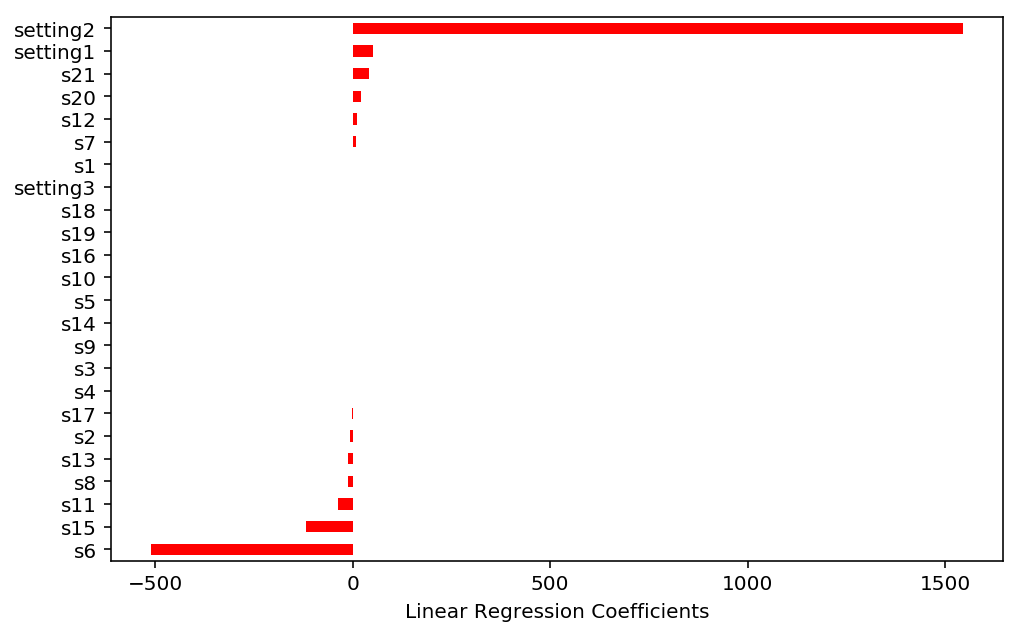

In [14]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

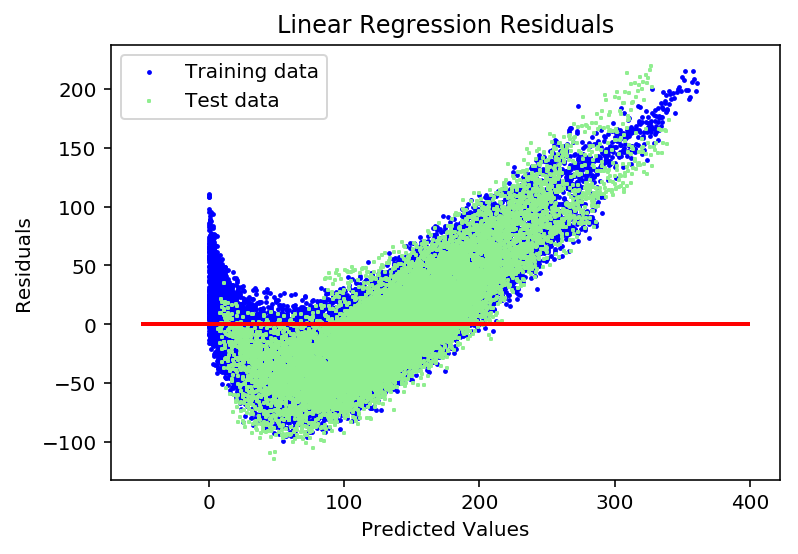

In [15]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

In [16]:
#try ridge

rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)

y_test_predict = rdg.predict(X_test)
y_train_predict = rdg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rdg_metrics = get_regression_metrics('Ridge Regression', y_test, y_test_predict)
rdg_metrics

R^2 training: 0.580, R^2 test: 0.327


,Ridge Regression
Root Mean Squared Error,48.384619
Mean Absolute Error,37.160916
R^2,0.326967
Explained Variance,0.337097


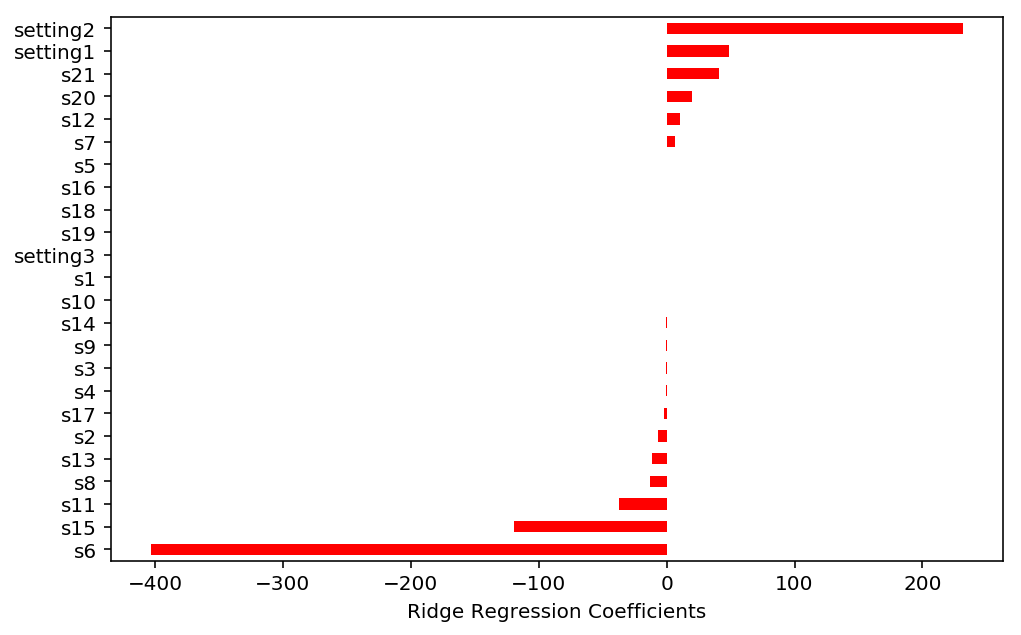

In [17]:
plot_features_weights('Ridge Regression', rdg.coef_, X_train.columns, 'c')

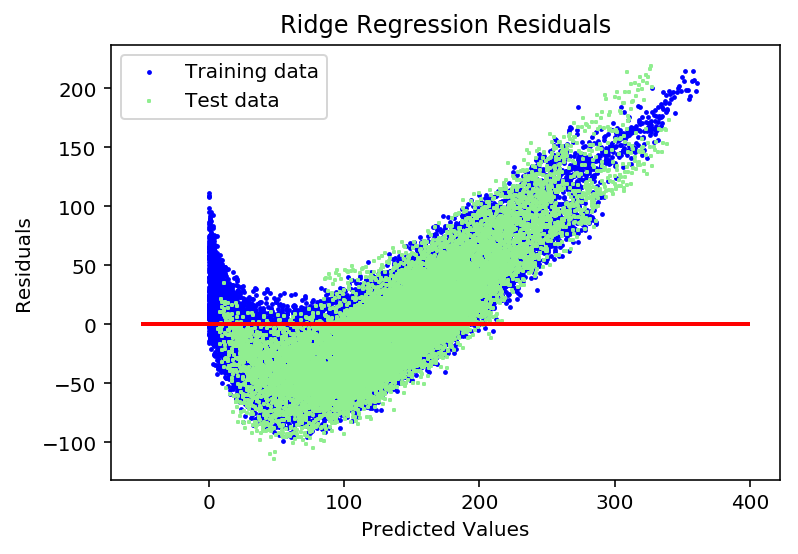

In [18]:
plot_residual('Ridge Regression', y_train_predict, y_train, y_test_predict, y_test)

## 다차항 모델

In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.626, R^2 test: 0.374


,Polynomial Regression
Root Mean Squared Error,46.661538
Mean Absolute Error,35.314111
R^2,0.374049
Explained Variance,0.375993


In [20]:
X_train.shape

(20631, 24)

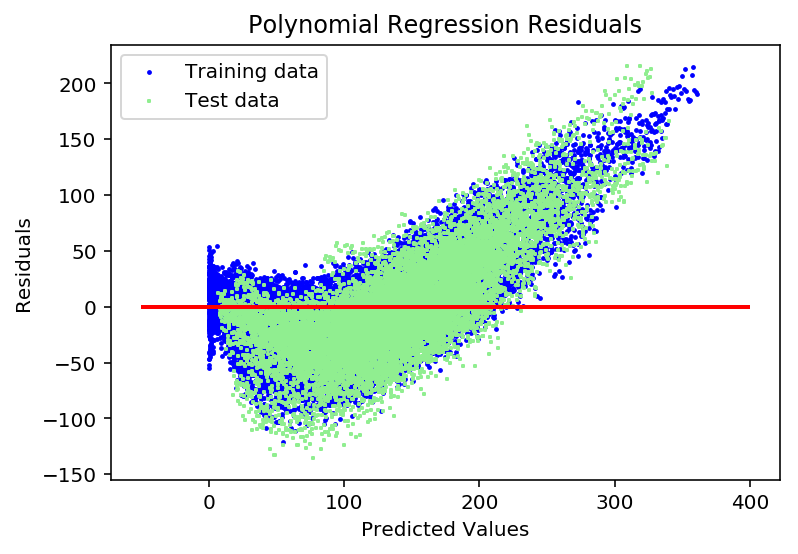

In [21]:
plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

- Polynomial 회귀의 성능이 선형 모델보다 더 낫다

## 랜덤 포레스트

In [22]:
rf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=4) # original features

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.594, R^2 test: 0.317


,Random Forest Regression
Root Mean Squared Error,48.737707
Mean Absolute Error,37.225802
R^2,0.317108
Explained Variance,0.342681


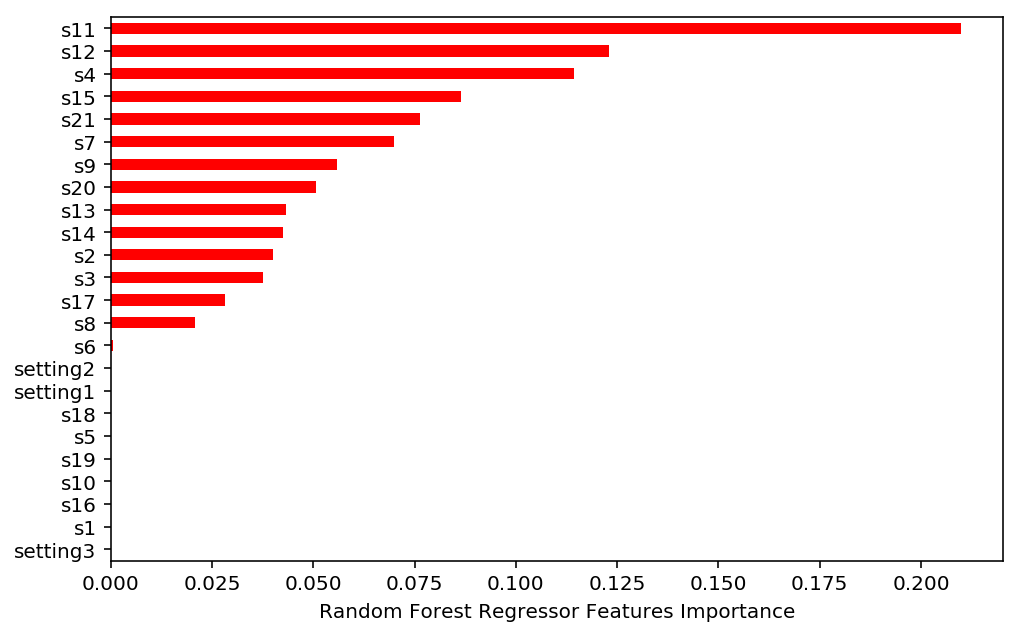

In [23]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

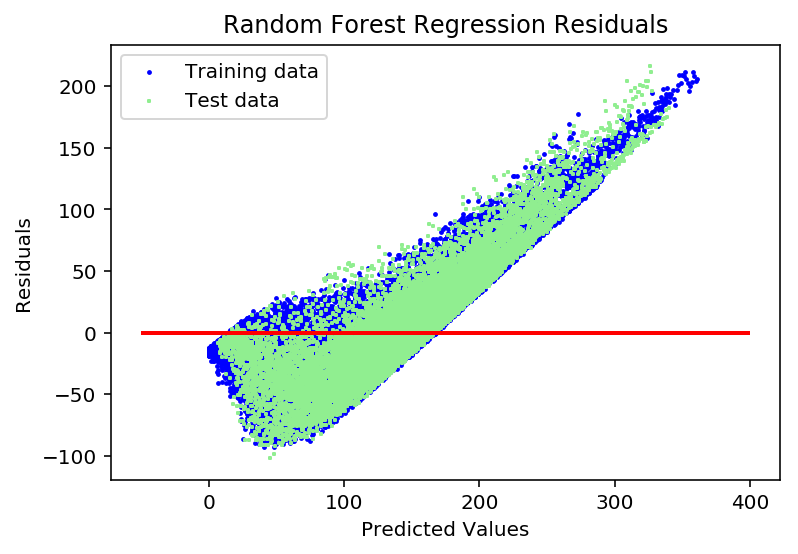

In [24]:
plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

## 실제값과 예측치 보기

In [25]:
rf_pred_dict = {
    'Actual' : y_test,
    'Prediction' : y_test_predict }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred

,0,1,2,3,4,5,6,7,8,9,...,13086,13087,13088,13089,13090,13091,13092,13093,13094,13095
Actual,142.000000,141.000000,140.000000,139.000000,138.000000,137.000000,136.000000,135.000000,134.000000,133.000000,...,29.000000,28.000000,27.0000,26.000000,25.000000,24.000000,23.000000,22.000000,21.000000,20.00000
Prediction,149.740779,151.316032,146.814636,148.299919,161.653715,155.633371,151.594523,150.230609,140.017704,159.932173,...,70.682814,66.006869,73.7827,65.740352,69.224987,47.635404,63.091056,73.003366,62.360159,36.55184
